<a href="https://colab.research.google.com/github/madhugopinathan/deep-nlu/blob/master/introduction_to_self_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Self Attention

In [0]:
import string
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
from tqdm import tqdm_notebook as tqdm

# Problem: Count A, B, |A-B| in a given sequence of A,B,C

In [0]:
def prettify(samples):
    samples = samples.reshape(-1, max_len, vocab_size)
    idx = np.expand_dims(np.argmax(samples, axis=2), axis=2)
    dictionary = np.array(list(string.ascii_uppercase))
    return dictionary[idx]

In [0]:
vocab_size = 3
batch_size = 2
max_len = 4

In [0]:
x = np.eye(vocab_size)[np.random.choice(np.arange(vocab_size), [batch_size, max_len])]

In [6]:
prettify(x)

array([[['C'],
        ['B'],
        ['A'],
        ['C']],

       [['C'],
        ['A'],
        ['C'],
        ['B']]], dtype='<U1')

In [0]:
y = x.sum(axis=1)
y[:,-1] = np.abs(y[:,0]-y[:,1])

In [8]:
y

array([[1., 1., 0.],
       [1., 1., 0.]])

## Generate Train / Val / Test

In [0]:
import torch
from torch import nn

In [0]:
def get_X_y(vocab_size=3, batch_size=32, max_len=4):
    x = np.eye(vocab_size)[np.random.choice(np.arange(vocab_size), [batch_size, max_len])]
    xt = torch.from_numpy(x).float()
    yt = xt.sum(dim=1).long()
    yt[:,-1] = torch.abs(yt[:,0] - yt[:,1])
    return xt, yt

In [0]:
vocab_size = 3
batch_size = 64
max_len = 10

train_set = []
val_set = []
test_set = []

for _ in range(1000):
    xt, yt = get_X_y(vocab_size=vocab_size, batch_size=batch_size, max_len=max_len)
    train_set.append((xt, yt))

for _ in range(100):
    xt, yt = get_X_y(vocab_size=vocab_size, batch_size=batch_size, max_len=max_len)
    val_set.append((xt, yt))

for _ in range(100):
    xt, yt = get_X_y(vocab_size=vocab_size, batch_size=batch_size, max_len=max_len)
    test_set.append((xt, yt))

## Model

In [0]:
class ABDiffCounter(nn.Module):
    def __init__(self, vocab_size=3, hidden_size=128, max_len=4, batch_size=32):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        
        self.tokeys_values = nn.Linear(vocab_size, hidden_size, bias=False)
        # b x v x h : v is the second dimension 
        # because we want a query vector for each element in the vocab
        self.query = nn.Parameter(data=torch.ones(batch_size, vocab_size, hidden_size))
        
        self.layernorm = nn.LayerNorm(self.hidden_size)

        # output is a classifier with t+1 classes: if t=4: [0,1,2,3,4]
        self.tocounts = nn.Linear(hidden_size, max_len+1)

    def attention(self, query, key, value):
        # (b x v x h) X (b x h x t) => b x v x t
        attn_weights = torch.bmm(query, key.transpose(1,2))
        attn_weights = attn_weights / torch.sqrt(torch.tensor(self.hidden_size).float())
        
        attn_probs = torch.softmax(attn_weights, dim=2)
        
        # b x v x h
        weighted_sum = torch.bmm(attn_probs, value)
        
        # b x v x h
        out = weighted_sum + query
        #print(out.size())
        #assert out.size() == x.size()
        
        out = self.layernorm(out)

        return attn_probs, out
    
    def forward(self, x):
        b, t, v = x.size()
        assert v == self.vocab_size
        
        # b x v x h
        #query = self.toqueries(x.transpose(1,2))
        query = self.query
        
        # b x t x h
        keys_values = self.tokeys_values(x)
        
        attn_probs, out = self.attention(self.query, keys_values, keys_values)

        self_attention_probs, out = self.attention(out, out, out)
        
        # b x v x (t+1)
        counts = self.tocounts(out)
        return attn_probs, self_attention_probs, counts

    
    def predict(self, x):
        attn_probs, self_attention_probs, counts = self.forward(x)
        return attn_probs, self_attention_probs, counts, torch.argmax(counts, dim=2)

## Train Model

In [17]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

model = ABDiffCounter(vocab_size=vocab_size, 
                   max_len=max_len,
                   hidden_size=64, 
                   batch_size=batch_size)
opt = torch.optim.Adam(lr=0.01, params=model.parameters())
sch = torch.optim.lr_scheduler.LambdaLR(opt, lambda i: min(i / (10000 / 2), 1.0))

epoch_train_losses = []
epoch_val_losses = []
epoch_val_accs = []

for e in tqdm(range(10)):
    model.train(True)
    train_losses = []
    for X, y in train_set:
        attn_probs, self_attention_probs, counts = model(X)
        loss = nn.functional.cross_entropy(counts.permute(0,2,1), y)
        train_losses.append(loss.item())
        loss.backward()
        opt.step()
        sch.step()
        opt.zero_grad()
    epoch_train_losses.append(np.mean(train_losses))
    
    model.train(False)
    val_losses = []
    val_accs = []
    for X, y in val_set:
        with torch.no_grad():
            attn_probs, self_attention_probs, counts, y_pred = model.predict(X)
            loss = nn.functional.cross_entropy(counts.permute(0,2,1), y)
            val_losses.append(loss.item())
            acc = (torch.argmax(counts,dim=2) == y).sum().float()/np.prod(y.size())
            val_accs.append(acc)
    epoch_val_losses.append(np.mean(val_losses))
    epoch_val_accs.append(np.mean(val_accs))

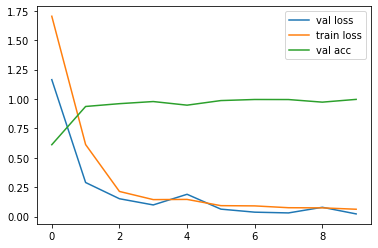

In [18]:
plt.plot(epoch_val_losses, label='val loss')
plt.plot(epoch_train_losses, label='train loss')
plt.plot(epoch_val_accs, label='val acc')
plt.legend()

In [19]:
epoch_val_accs

[0.6108854,
 0.9359897,
 0.9598438,
 0.9778647,
 0.94713545,
 0.9862499,
 0.99536455,
 0.9948959,
 0.9728125,
 0.9963021]

In [0]:
def plot_attn():
    # choose a random idx
    test_bidx = np.random.randint(len(test_set))
    
    idx = np.random.randint(batch_size)
    X, y =test_set[test_bidx]

    print(prettify(X[idx]))
    
    model.train(False)
    with torch.no_grad():
        attn_probs, self_attention_probs, counts, y_pred = model.predict(X)
    print(y[idx])
    print(y_pred[idx])
    fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(16,4))

    sns.heatmap(attn_probs[idx].detach().numpy(), ax=ax0, 
                xticklabels=prettify(X[idx]).squeeze(),
                yticklabels=['A','B','DIFF'])
    sns.heatmap(self_attention_probs[idx].detach().numpy(), ax=ax1,
                xticklabels=['A','B','DIFF'],
                yticklabels=['A','B','DIFF']
               )
    ax1.set_aspect('equal')
    plt.tight_layout()

[[['C']
  ['B']
  ['A']
  ['B']
  ['A']
  ['B']
  ['C']
  ['B']
  ['C']
  ['A']]]
tensor([3, 4, 1])
tensor([3, 4, 1])


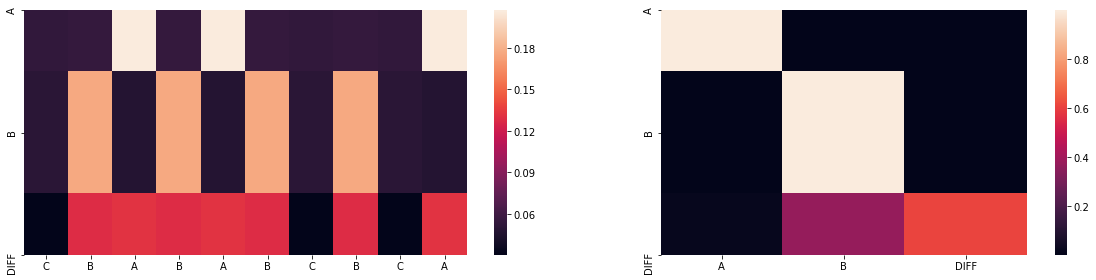

In [25]:
plot_attn()

# References

1. [Neural Machine Translation by Jointly Learning to Align and Translate, Bahdanau et. al.](https://arxiv.org/abs/1409.0473)
1. [Effective Approaches to Attention-based Neural Machine Translation, Luong et. al.](https://arxiv.org/abs/1508.04025)
1. [Attention is All You Need, Vaswani et. al.](https://arxiv.org/abs/1706.03762)
1. [Lecture 14, Transformers and Self Attention, Stanford CS 224N](https://www.youtube.com/watch?v=5vcj8kSwBCY)
1. [Speech and Language Processing, Jurafsky and Martin, Section 10.3](https://web.stanford.edu/~jurafsky/slp3/10.pdf)
1. [Attention Primer](https://github.com/greentfrapp/attention-primer)
1. [Transformers from Scratch](http://www.peterbloem.nl/blog/transformers)